In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from dateutil.parser import parse
import numpy as np
import seaborn as sns
import warnings
import datetime as dt
warnings.filterwarnings('ignore')

In [2]:
# Carga de archivos
post_educacion = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas = pd.read_csv('../data/fiuba_3_vistas.csv', parse_dates=['timestamp'])
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
    'nombre_area': 'category'
})


# Ajustes en los archivos antes de procesar

In [3]:
vistas.rename(columns={"idAviso":"idaviso"}, inplace=True)
vistas.rename(columns={"timestamp":"fechavista"}, inplace=True)

# Cambiar el tipo de dato de la fecha de vista.
vistas[['fechavista']] = vistas[['fechavista']].apply(pd.to_datetime)
now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)

Timestamp('2018-04-07 19:23:05.413085')

In [4]:
# Recorto la columna idpais ya que no es necesaria.
avisos_detalles.drop('idpais', axis=1, inplace=True)
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

# Cambiar el tipo de dato de la fecha de postulacion.
postulaciones[['fechapostulacion']] = postulaciones[['fechapostulacion']].apply(pd.to_datetime)
now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)

Timestamp('2018-04-07 19:23:30.966816')

# Empieza el analisis

In [5]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa de cada postulante.
valores_educacion = [{'nombre': 'Otro', 'estado': 'Abandonado',    'valor_educacion': 1    },
    {'nombre': 'Otro',                  'estado': 'En Curso',    'valor_educacion': 2    },
    {'nombre': 'Otro',                  'estado': 'Graduado',    'valor_educacion': 3    },
    {'nombre': 'Secundario',            'estado': 'Abandonado',    'valor_educacion': 4    },
    {'nombre': 'Secundario',            'estado': 'En Curso',    'valor_educacion': 5    },
    {'nombre': 'Secundario',        'estado': 'Graduado',    'valor_educacion': 6    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Abandonado',    'valor_educacion': 7    },
    {'nombre': 'Universitario',     'estado': 'Abandonado',    'valor_educacion': 8    },
    {'nombre': 'Terciario/Técnico', 'estado': 'En Curso',    'valor_educacion': 9    },
    {'nombre': 'Universitario',     'estado': 'En Curso',    'valor_educacion': 10    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Graduado',    'valor_educacion': 11    },
    {'nombre': 'Universitario',     'estado': 'Graduado',    'valor_educacion': 12    },
    {'nombre': 'Posgrado',          'estado': 'Abandonado',    'valor_educacion': 13    },
    {'nombre': 'Master',            'estado': 'Abandonado',    'valor_educacion': 14    },
    {'nombre': 'Posgrado',          'estado': 'En Curso',    'valor_educacion': 15    },
    {'nombre': 'Master',            'estado': 'En Curso',    'valor_educacion': 16    },
    {'nombre': 'Posgrado',          'estado': 'Graduado',    'valor_educacion': 17    },
    {'nombre': 'Master',            'estado': 'Graduado',    'valor_educacion': 18    },
    {'nombre': 'Doctorado',         'estado': 'Abandonado',    'valor_educacion': 19    },
    {'nombre': 'Doctorado',         'estado': 'En Curso',    'valor_educacion': 20    },
    {'nombre': 'Doctorado',         'estado': 'Graduado',    'valor_educacion': 21 }]
valores_educacion = pd.DataFrame(valores_educacion)

In [6]:
valores_educacion.nombre = valores_educacion.nombre.astype('category', categories=post_educacion.nombre.cat.categories)
valores_educacion.memory_usage(deep=True)

Index                80
estado             1379
nombre              850
valor_educacion     168
dtype: int64

In [7]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion,  how='inner', \
                          left_on=['nombre','estado'], right_on = ['nombre','estado'])

In [8]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()
max_post_educacion.count()

idpostulante       188752
valor_educacion    188752
dtype: int64

In [9]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', \
                          left_on=['idpostulante','valor_educacion'], right_on = ['idpostulante','valor_educacion'])

post_educacion.head()

,idpostulante,nombre,estado,valor_educacion
0,NdJl,Posgrado,En Curso,15
1,axaPJ,Posgrado,En Curso,15
2,Z48mz,Posgrado,En Curso,15
3,a4zEZ,Posgrado,En Curso,15
4,6AWqO,Posgrado,En Curso,15


In [10]:
postulantes = pd.merge(post_educacion, post_gen_edad)
pd.to_datetime(postulantes['fechanacimiento'])
postulantes['edad'] = (now - pd.to_datetime(postulantes['fechanacimiento'])).astype('<m8[Y]')
postulantes.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad
0,NdJl,Posgrado,En Curso,15,1969-05-09,MASC,48.0
1,axaPJ,Posgrado,En Curso,15,1970-01-06,MASC,48.0
2,Z48mz,Posgrado,En Curso,15,1967-05-16,MASC,50.0
3,a4zEZ,Posgrado,En Curso,15,1976-04-10,MASC,41.0
4,6AWqO,Posgrado,En Curso,15,1970-05-21,MASC,47.0


# Relacion entre cantidad de postulaciones y vistas por aviso

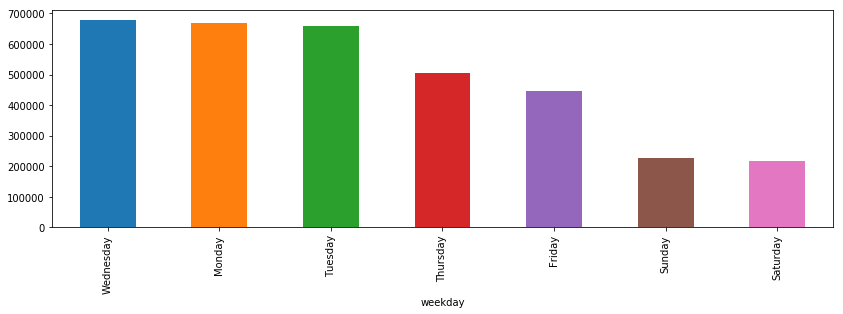

In [12]:
#cantidad de postulaciones por dia de semana
post_weekday = postulaciones
post_weekday['weekday'] =  post_weekday['fechapostulacion'].dt.weekday_name
post_weekday.groupby('weekday').count()['fechapostulacion'].sort_values(ascending=False)[0:19].plot(kind='bar',figsize=(14,4));

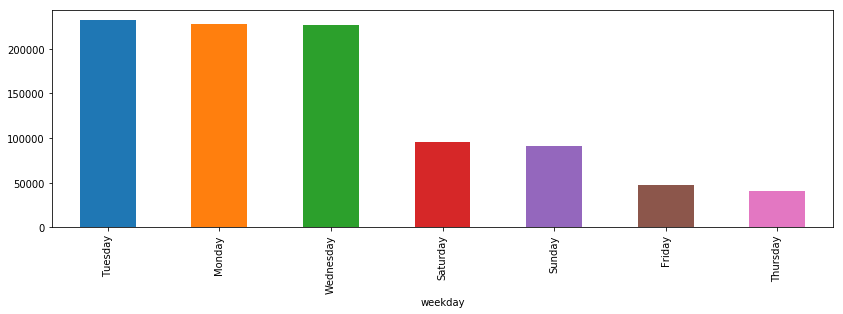

In [13]:
#cantidad de vistas por dia de semana
vistas_weekday = vistas
vistas_weekday['weekday'] =  vistas_weekday['fechavista'].dt.weekday_name
vistas_weekday.groupby('weekday').count()['fechavista'].sort_values(ascending=False)[0:19].plot(kind='bar',figsize=(14,4));

In [14]:
#cantidad de postulaciones
avisos_cant_post = postulaciones.loc[:,['idaviso']]
avisos_cant_post = avisos_cant_post.groupby(['idaviso']).size()
avisos_cant_post = avisos_cant_post.sort_values(ascending=False)
avisos_cant_post = pd.DataFrame(avisos_cant_post).reset_index()
avisos_cant_post[["idaviso", "cant_post"]] = avisos_cant_post[["idaviso", 0]]
avisos_cant_post = avisos_cant_post[["idaviso", "cant_post"]]  
avisos_cant_post.head()

,idaviso,cant_post
0,1112033906,9932
1,1112334791,9787
2,1112204682,9244
3,1112094756,8763
4,1112345900,8304


In [15]:
#cantidad de vistas
avisos_cant_vistas = vistas.loc[:,['idaviso']]
avisos_cant_vistas = avisos_cant_vistas.groupby(['idaviso']).size()
avisos_cant_vistas = avisos_cant_vistas.sort_values(ascending=False)
avisos_cant_vistas = pd.DataFrame(avisos_cant_vistas).reset_index()
avisos_cant_vistas[["idaviso", "cant_vistas"]] = avisos_cant_vistas[["idaviso", 0]]
avisos_cant_vistas = avisos_cant_vistas[["idaviso", "cant_vistas"]]  
avisos_cant_vistas.head()

,idaviso,cant_vistas
0,1112363488,4169
1,1112359836,4120
2,1112352317,4003
3,1112366909,3669
4,1112355872,3472


In [16]:
#relacion
post_vs_vistas =  pd.merge(avisos_cant_post, avisos_cant_vistas, on="idaviso", how='inner')
post_vs_vistas = post_vs_vistas[["idaviso", "cant_post", "cant_vistas"]] 
post_vs_vistas.head()

,idaviso,cant_post,cant_vistas
0,1112033906,9932,22
1,1112334791,9787,2817
2,1112204682,9244,18
3,1112094756,8763,6
4,1112345900,8304,2841


In [17]:
#cantidad vistas = cantidad de vistas + cantidad de postulaciones
post_vs_vistas['cant_vistas'] = post_vs_vistas.cant_vistas + post_vs_vistas.cant_post
post_vs_vistas.head()

,idaviso,cant_post,cant_vistas
0,1112033906,9932,9954
1,1112334791,9787,12604
2,1112204682,9244,9262
3,1112094756,8763,8769
4,1112345900,8304,11145


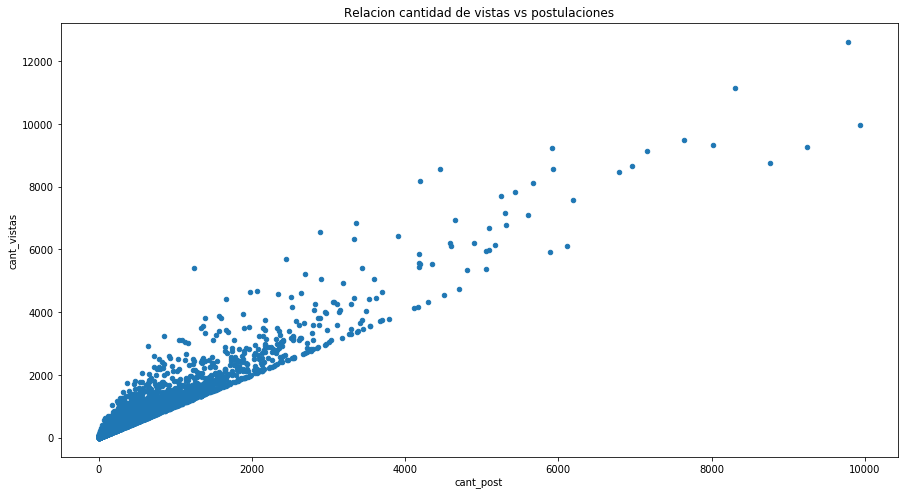

In [18]:
post_vs_vistas.plot.scatter('cant_post','cant_vistas',alpha=1,title = "Relacion cantidad de vistas vs postulaciones",figsize=(15,8));

In [19]:
#calculo la probabilidad de que alguien se postule
post_vs_vistas['prob_post'] = post_vs_vistas.cant_post / post_vs_vistas.cant_vistas
post_vs_vistas = post_vs_vistas.sort_values(by='prob_post', ascending=True)
post_vs_vistas.head()

,idaviso,cant_post,cant_vistas,prob_post
6509,1112359511,2,133,0.015038
6508,1112361790,2,112,0.017857
6517,1112361607,1,32,0.031250
6515,1112361795,1,26,0.038462
6524,1111873421,1,16,0.062500


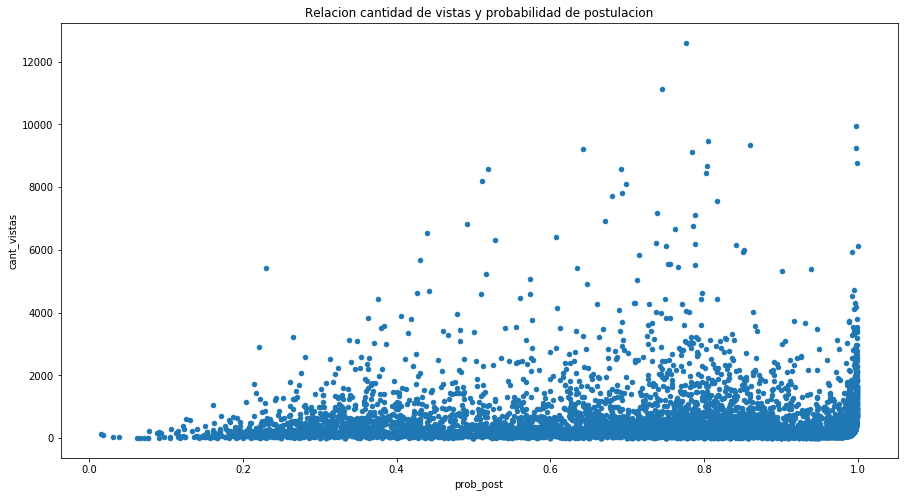

In [20]:
post_vs_vistas.plot.scatter('prob_post','cant_vistas',alpha=1,title = "Relacion cantidad de vistas y probabilidad de postulacion",figsize=(15,8));

In [21]:
post_vs_vistas_detalle = post_vs_vistas.merge(avisos_detalles, on="idaviso")
post_vs_vistas_detalle.head()

,idaviso,cant_post,cant_vistas,prob_post,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,1112359511,2,133,0.015038,Docentes,<p>Nos encontramos en la bùsqueda de docentes ...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Educación/ Docentes,Neo-Biz Consultores
1,1112361790,2,112,0.017857,Esto es un aviso de prueba,<p>TesttestestTesttestestTesttestestTesttestes...,Capital Federal,NaN,rondeau 2664,Full-time,Senior / Semi-Senior,Tecnologia / Sistemas,TEST MDAN2
2,1112361607,1,32,0.031250,Desarrollador Back End - Senior,<p>Importante empresa de Software especializad...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Programación,NG Empleos
3,1112361795,1,26,0.038462,"Looking for Automotive, Telematics and Connect...","<p style="""">On behalf of our customer Telescop...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Programación,Telescope Services
4,1111873421,1,16,0.062500,Traductor/a interprete chino,"<p style=""""><strong>Adecco Office</strong> est...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Traduccion,Adecco - Región Centro Norte y Agro.


In [22]:
#filtro campos importantes
post_vs_vistas_detalle = post_vs_vistas_detalle.loc[:, ['idaviso','cant_post','cant_vistas','prob_post','tipo_de_trabajo','nivel_laboral','nombre_area','denominacion_empresa']]
post_vs_vistas_detalle.head()

,idaviso,cant_post,cant_vistas,prob_post,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,1112359511,2,133,0.015038,Full-time,Senior / Semi-Senior,Educación/ Docentes,Neo-Biz Consultores
1,1112361790,2,112,0.017857,Full-time,Senior / Semi-Senior,Tecnologia / Sistemas,TEST MDAN2
2,1112361607,1,32,0.031250,Full-time,Senior / Semi-Senior,Programación,NG Empleos
3,1112361795,1,26,0.038462,Full-time,Senior / Semi-Senior,Programación,Telescope Services
4,1111873421,1,16,0.062500,Full-time,Senior / Semi-Senior,Traduccion,Adecco - Región Centro Norte y Agro.


In [23]:
avisos_vs_post = post_vs_vistas.merge(postulaciones, on="idaviso")
avisos_vs_post.head()

,idaviso,cant_post,cant_vistas,prob_post,idpostulante,fechapostulacion,weekday
0,1112359511,2,133,0.015038,QNLVQaV,2018-02-26 20:35:10,Monday
1,1112359511,2,133,0.015038,BmaW2ZE,2018-02-28 08:35:54,Wednesday
2,1112361790,2,112,0.017857,12OGdj,2018-02-26 09:46:39,Monday
3,1112361790,2,112,0.017857,Yj53ppD,2018-02-27 14:58:38,Tuesday
4,1112361607,1,32,0.031250,bOZkaeV,2018-02-26 09:15:16,Monday
